# Machine learning Avec Spark/Python (MLlib/ Linear Support Vector Machines (SVM) /HDFS)

In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import when
import numpy as np
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import mean
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import *


# Create Spark Session


In [2]:
spark = SparkSession.builder.appName("Projetbd").getOrCreate()


2022-12-26 14:33:52,749 WARN util.Utils: Your hostname, miloudi-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.79.129 instead (on interface ens33)
2022-12-26 14:33:52,750 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-12-26 14:33:54,516 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

# UPLOADING DATA FROM HDFS

In [4]:
df = spark.read.csv("hdfs:///projet/cardio.csv",header=True, sep=';',inferSchema=True)

In [5]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [6]:
df.show(5)

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



In [7]:
df=df.drop("id")


In [9]:
df.show(5)

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



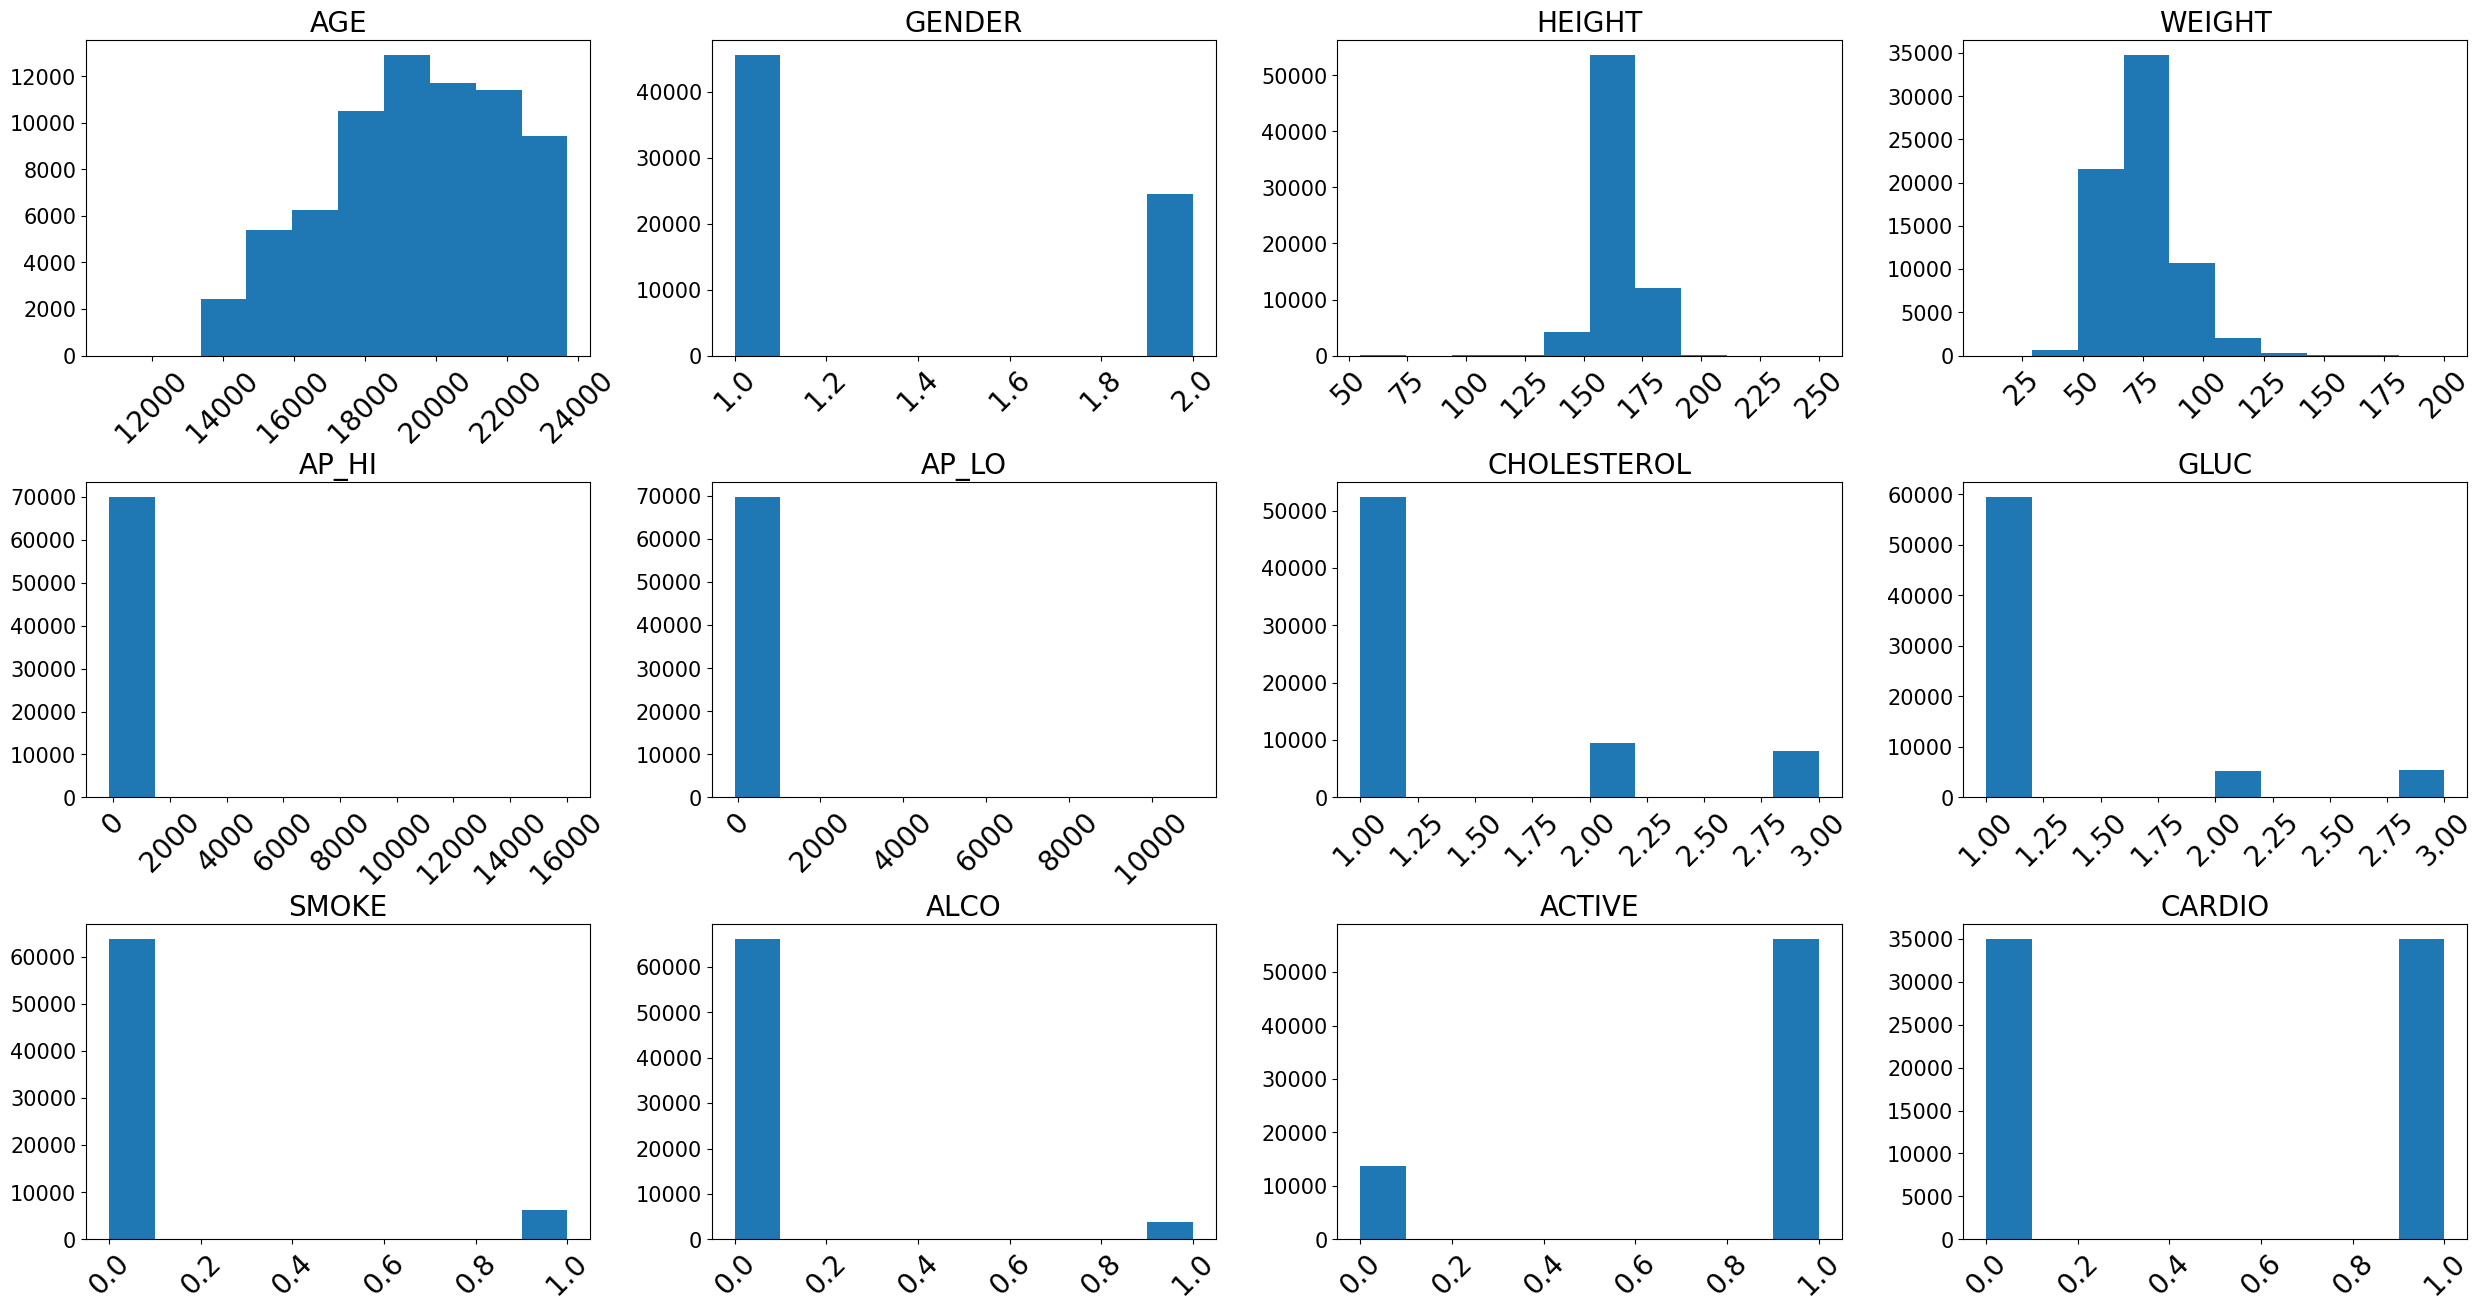

In [11]:
fig = plt.figure(figsize=(25, 15))
for colm, num in zip(df.toPandas().describe().columns, range(1,20)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[colm])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(colm.upper(), fontsize=20)

plt.tight_layout()
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [12]:
df.groupby('cardio').count().show()


+------+-----+
|cardio|count|
+------+-----+
|     1|34979|
|     0|35021|
+------+-----+



# Checking null values

In [13]:
def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
if null_columns_calc_list : 
    spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()
else :
    print("Data is clean with no null values")


Data is clean with no null values


# PUTTING FEATURES INTO A FEATURE VECTOR COLUMN

In [14]:
assembler = VectorAssembler(inputCols = ["age","gender","height","weight","ap_hi","ap_lo","cholesterol","gluc","smoke","alco","active"], outputCol='features')
output_data = assembler.transform(df)
output_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- features: vector (nullable = true)



In [15]:
final_data = output_data.select('features','cardio')


In [16]:
final_data.show()

+--------------------+------+
|            features|cardio|
+--------------------+------+
|[18393.0,2.0,168....|     0|
|[20228.0,1.0,156....|     1|
|[18857.0,1.0,165....|     1|
|[17623.0,2.0,169....|     1|
|[17474.0,1.0,156....|     0|
|[21914.0,1.0,151....|     0|
|[22113.0,1.0,157....|     0|
|[22584.0,2.0,178....|     1|
|[17668.0,1.0,158....|     0|
|[19834.0,1.0,164....|     0|
|[22530.0,1.0,169....|     0|
|[18815.0,2.0,173....|     0|
|[14791.0,2.0,165....|     0|
|[19809.0,1.0,158....|     0|
|[14532.0,2.0,181....|     0|
|[16782.0,2.0,172....|     1|
|[21296.0,1.0,170....|     0|
|[16747.0,1.0,158....|     0|
|[17482.0,1.0,154....|     0|
|[21755.0,2.0,162....|     0|
+--------------------+------+
only showing top 20 rows



In [17]:
final_data.printSchema()


root
 |-- features: vector (nullable = true)
 |-- cardio: integer (nullable = true)



# SPLITTING DATA

In [18]:
train, test = final_data.randomSplit([0.8,0.2]) 

# USING CROSSVALIDATOR FOR HYPERPARAMETERS TUNNING

In [19]:
svm = LinearSVC(labelCol='cardio')


In [20]:
paramGrid = (ParamGridBuilder()
             .addGrid(svm.regParam, [0.1, 0.01, 0.001])
             .addGrid(svm.tol, [1e-6, 1e-5, 1e-4])
             .build())

In [21]:
evaluator = BinaryClassificationEvaluator(labelCol='cardio',metricName="areaUnderROC")


In [22]:
cv = CrossValidator(estimator=svm,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

In [23]:
model = cv.fit(train)


2022-12-25 21:38:41,441 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2022-12-25 21:38:41,448 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [24]:
predictions = model.transform(test)

In [25]:
evaluator = BinaryClassificationEvaluator(labelCol='cardio')
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7805399054653943
